In [ ]:
! pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install git+https://github.com/qubvel/segmentation_models.pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-7gxqd0d5
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-7gxqd0d5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.0.dev0-py3-none-any.whl size=98008 sha256=1c37ce3bf0decaee5b093631162c60917d1a59461163c08b3e0d4581c73207fe
  Stored in directory: /tmp/pip-ephem-wheel-cache-idp89jgu/wheels/fa/c5/a8/1e8af6cb04a0974db8a4a156ebd2fdd1d99ad2558d3fce49d4
Successfully built segmentation-models-pytorch
  Attempting uninstall: segmentation-models-pytorch
    Found existing installation: segmentation-models-pytorch 0.2.1
    Uninstalling segmentation-models-pytorch-0.2.1:
      Successfully uninsta

In [ ]:
#Imports
import torch
from torch.utils.data import Dataset
from torchvision import datasets, models
from torchvision import transforms as T
from torchvision.transforms import ToTensor
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import PIL
from PIL import Image
from glob import glob
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
#GET Data
from google.colab import files
files.upload() #Upload kaggle.json here.

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
#Unzip and download files
!mkdir aisegment-split-1
%cd aisegment-split-1
!kaggle datasets download -d vincenttu/aisegment-split-1
!unzip -q aisegment-split-1.zip
!rm aisegment-split-1.zip
%cd

/content/aisegment-split-1
100% 3.55G/3.56G [00:28<00:00, 118MB/s]
100% 3.56G/3.56G [00:28<00:00, 133MB/s]
/root


In [ ]:
#set up paths
filepaths = list(glob('/content/aisegment-split-1/*'))

#Extract data and label sets
label_paths = []
image_paths = []
for path in filepaths:
  if 'label' in path:
    label_paths.append(path)
  else:
    image_paths.append(path)
  
for x in label_paths:
  y = x.split("_")[1]
  y = '/content/aisegment-split-1/' + y
  if y not in image_paths:
    label_paths.remove(x)

#remove bad data
label_paths.remove('/content/aisegment-split-1/label_1803201916-00000002.jpg')
image_paths.remove('/content/aisegment-split-1/1803201916-00000002.jpg')

#sort data
label_paths.sort()
image_paths.sort()

In [ ]:
#Create custom dataset
from torchvision.transforms.transforms import ToTensor
class SegmentDataset(Dataset):
  def __init__(self, images_path, labels_path):
    self.images_path = images_path
    self.labels_path = labels_path

    self.transform_both = T.Compose([
        T.ToTensor(),            
        T.Resize((128, 128))  #arbitrary multiple of 32    
    ])

    self.transform_image = T.Compose([
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    self.transform_label = T.Compose([
                            
    ])

  def __len__(self):
    return len(self.images_path)

  def __getitem__(self, idx):
    image = PIL.Image.open(self.images_path[idx])
    label = PIL.Image.open(self.labels_path[idx])

    image_array = np.asarray(image)

    #make into array, get only alpha color channel, expand to make 3D(with C.C.)
    label_array = np.expand_dims(np.asarray(label)[:,:,3], axis=2)
    
    image_tensor = self.transform_both(image_array)
    label_tensor = self.transform_both(label_array)

    #only transform images (training set) cause it goes through model
    image_tensor = self.transform_image(image_tensor)
    label_tensor = self.transform_label(label_tensor)

    label_tensor = (label_tensor>0).type(torch.FloatTensor)  # np.float32, float

    return image_tensor, label_tensor

In [ ]:
#create model
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
#Variable instatiation
batch_size = 32
data = SegmentDataset(image_paths, label_paths)

train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])

#loaders
loaders = {
    'train' : torch.utils.data.DataLoader(train_dataset, 
                                          batch_size=32, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=32, 
                                          shuffle=False, 
                                          num_workers=1),
}


device = 'cuda' if torch.cuda.is_available() else 'cpu'

#model params
num_epochs=5
learning_rate = 0.01
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)

In [ ]:
#Training Loop
def train_model(model, optimizer, num_epochs=5):
  for epoch in range(num_epochs):
      for i, batch in tqdm(enumerate(loaders['train'])):
          image, label = batch 
          image = image.to(device)
          label = label.to(device)

          # Forward pass
          outputs = model(image)

          loss = F.binary_cross_entropy(torch.sigmoid(outputs), label)
          
          optimizer.zero_grad()
          # Backward and optimize
          loss.backward()
          optimizer.step()


      print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
#train model
trained_model=train_model(model,nn.BCELoss,optimizer)

In [ ]:
#WARNING!

#Only run this cell if you have trained a model. Saves and loads newly trained model.
PATH='/content/model.pt'
torch.save(model, PATH)
loaded_model = torch.load(PATH)


In [ ]:
#Loads old model.
PATH='/content/model.pt'
loaded_model = torch.load(PATH)

In [ ]:
#Test model
loaded_model.eval()
imgs=[]
masks=[]
with torch.no_grad():
  #Tests one batch
  for images, labels in loaders['test']:
    images = images.to(device)
    labels = labels.to(device)

    out=torch.sigmoid(loaded_model(images))
    break

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:133: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


In [ ]:
out.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

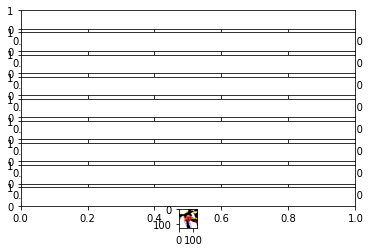

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


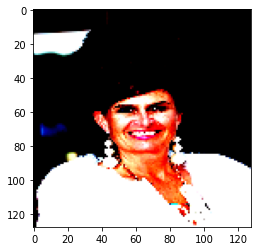

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


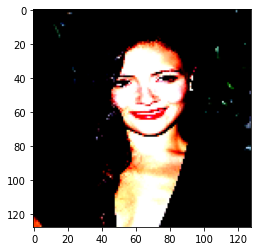

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


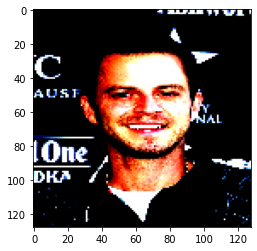

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


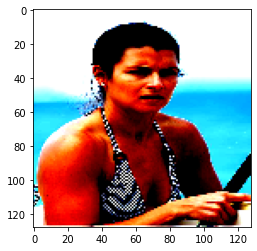

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


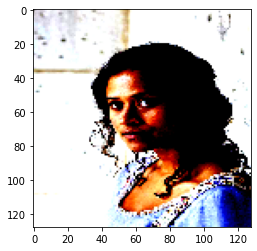

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


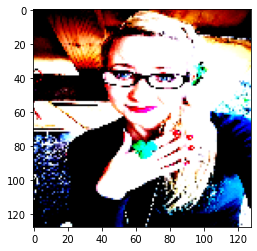

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


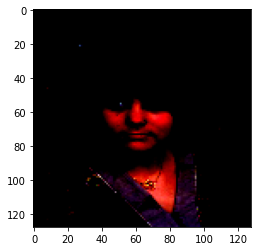

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


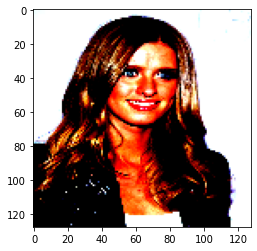

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


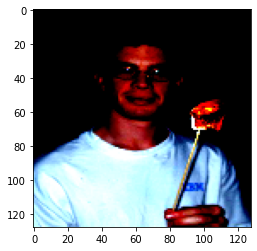

In [ ]:
#displays some images from 1 batch
plt.figure()
f, axarr = plt.subplots(10,1) 
for i in range(10):
  plt.imshow(images[i].cpu().permute(1, 2, 0))
  plt.show()

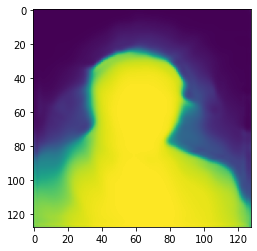

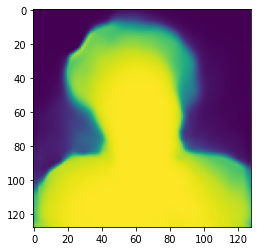

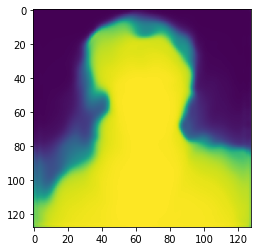

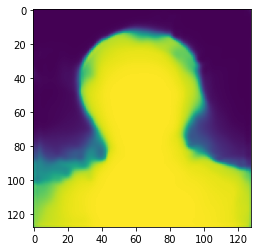

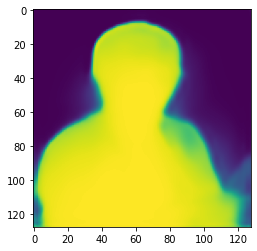

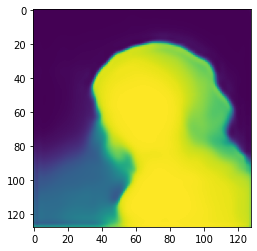

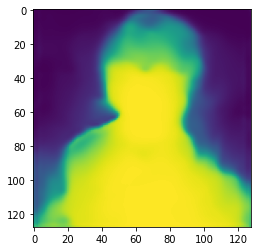

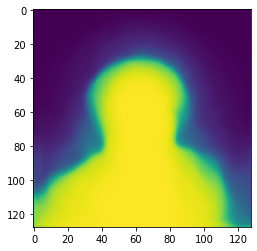

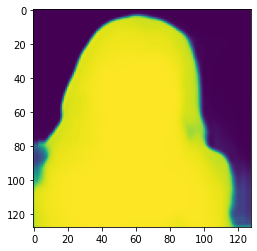

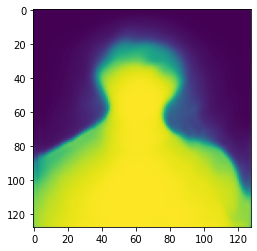

In [ ]:
#displays maska from 1 batch. corresponds to images above.
for i in range(10):
  plt.imshow(out[i].cpu().squeeze())
  plt.show()